Accessor
========



## Working with swath files



### The SwathGridFiles object



If we have a collection of time-series swath files, we can create a `SwathGridFiles` object that will handle fetching and reading requested swath files by time and geographic area.



In [1]:
from datetime import datetime
from importlib import reload
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

import numpy as np
import ascat.read_native.swath_collection as scol
import ascat.read_native.xarray.indices as idxs
from ascat.read_native.xarray import accessor
reload(scol)

from time import time

In [2]:
swath_source = "/home/charriso/p14/data-write/RADAR/hsaf/h121_v1.0/swaths"

It&rsquo;s important to understand the structure of the data, so that the SwathGridFiles object can find and parse all of the data that is requested from it. Handily, this package comes with existing parsers for several ASCAT products. These can be used with `SwathFileCollection.from_product_id()`:



In [3]:
sgf = scol.SwathGridFiles.from_product_id(swath_source, "h121_v1.0")

### Extracting data with `SwathGridFiles`



Let&rsquo;s start with a rectangular, roughly country-sized area in Central Europe, and a time period of four days.



In [4]:
bounds = (45, 50, 10, 20) #latmin, latmax, lonmin, lonmax
dates = (datetime(2020, 12, 1), datetime(2020, 12, 5))

By calling the `extract` method of `SwathGridFiles`, we open every dataset within the `date_range` we&rsquo;ve passed, concatenate them together into an xarray dataset, and filter out any observations that don&rsquo;t intersect with the bounding box we&rsquo;ve passed to `bbox`. Other spatial selections we could pass to `extract` are `cell` (cell number or list of cell numbers in the swath data&rsquo;s grid system), `location_id` (grid point ID or list of IDs in the swath data&rsquo;s grid system), `coords` (lat/lon coordinate or list of coordinates that will be converted to the nearest grid point ID or list of grid point IDs), or `geom` (a Shapely geometry).

(I&rsquo;m still not sure about the best name for this method - I wanted to move away from &ldquo;read&rdquo;, because I&rsquo;m not actually reading in all the data but rather opening a multifile dataset. But I&rsquo;m not sure if using `open_mfdataset` is good either, since it doesn&rsquo;t take the same arguments as the xarray function)

(also - I need to harmonize the arguments to this method between SwathGridFiles and CellGridFiles)



In [5]:
from ascat.read_native import xarray_ext as xae
output = sgf.extract(dates[0], dates[1], bbox=bounds)#, date_field_fmt="%Y%m%d%H%M%S")
output.load()
# output.swath.sel_spatial(location_id=[1258693, 1260455])
# output.swath.sel_spatial(bbox=(46,48, 14, 16))

<xarray.Dataset> Size: 6MB
Dimensions:                            (obs: 45007)
Coordinates:
    latitude                           (obs) float64 360kB 49.91 49.96 ... 50.0
    longitude                          (obs) float64 360kB 19.94 19.78 ... 11.26
    time                               (obs) datetime64[ns] 360kB 2020-12-01T...
Dimensions without coordinates: obs
Data variables: (12/19)
    location_id                        (obs) int32 180kB 1258693 ... 1260455
    as_des_pass                        (obs) float32 180kB 1.0 1.0 ... 0.0 0.0
    swath_indicator                    (obs) float32 180kB 0.0 0.0 ... 1.0 1.0
    surface_soil_moisture              (obs) float64 360kB 22.42 25.39 ... 35.41
    surface_soil_moisture_noise        (obs) float64 360kB 6.4 6.17 ... 3.55
    backscatter40                      (obs) float64 360kB -9.284 ... -9.831
    ...                                 ...
    snow_cover_probability             (obs) float32 180kB 70.0 68.0 ... 48.0
    frozen_soil_probability            (obs) float32 180kB 31.0 29.0 ... 48.0
    wetland_fraction                   (obs) float32 180kB nan nan ... 0.0 nan
    topographic_complexity             (obs) float32 180kB 6.0 3.0 ... 6.0 4.0
    subsurface_scattering_probability  (obs) float32 180kB nan nan ... nan nan
    sat_id                             (obs) int64 360kB 3 3 3 3 3 ... 5 5 5 5 5
Attributes:
    grid_name:  Fib12.5

Now we&rsquo;ve stitched together all the data we want. If we want to make some further selections from it, though, we still don&rsquo;t have a super easy way with default xarray, especially since our coordinates (except for time) don&rsquo;t have indices.

We can solve this problem by setting a custom index on the dataset. We&rsquo;ll do it manually here but in the future, datasets can come out of the readers with this index set by default.



In [6]:
ds = output.set_coords("location_id").set_xindex("location_id", idxs.FibGridIndex, spacing=12.5)
ds

<xarray.Dataset> Size: 6MB
Dimensions:                            (obs: 45007)
Coordinates:
  * location_id                        (obs) int32 180kB 1258693 ... 1260455
    latitude                           (obs) float64 360kB 49.91 49.96 ... 50.0
    longitude                          (obs) float64 360kB 19.94 19.78 ... 11.26
    time                               (obs) datetime64[ns] 360kB 2020-12-01T...
Dimensions without coordinates: obs
Data variables: (12/18)
    as_des_pass                        (obs) float32 180kB 1.0 1.0 ... 0.0 0.0
    swath_indicator                    (obs) float32 180kB 0.0 0.0 ... 1.0 1.0
    surface_soil_moisture              (obs) float64 360kB 22.42 25.39 ... 35.41
    surface_soil_moisture_noise        (obs) float64 360kB 6.4 6.17 ... 3.55
    backscatter40                      (obs) float64 360kB -9.284 ... -9.831
    slope40                            (obs) float64 360kB -0.1156 ... -0.1068
    ...                                 ...
    snow_cover_probability             (obs) float32 180kB 70.0 68.0 ... 48.0
    frozen_soil_probability            (obs) float32 180kB 31.0 29.0 ... 48.0
    wetland_fraction                   (obs) float32 180kB nan nan ... 0.0 nan
    topographic_complexity             (obs) float32 180kB 6.0 3.0 ... 6.0 4.0
    subsurface_scattering_probability  (obs) float32 180kB nan nan ... nan nan
    sat_id                             (obs) int64 360kB 3 3 3 3 3 ... 5 5 5 5 5
Indexes:
    location_id  FibGridIndex(spacing=12.5)
Attributes:
    grid_name:  Fib12.5

In this fork I&rsquo;ve added a `.gridds` (for grid dataset, bad name i know) accessor based on the implementation of the `.dggs` accessor in the prototype `xdggs` xarray extension (link). Everything here could be done using `xdggs` instead, except for the `.sel_bbox` method, which I added here (but perhaps we could work with the xdggs folks to add some nice functionality like this). The main reason I&rsquo;ve used a custom implementation in this example is that `xdggs` currently requires python 3.10 or above, and I&rsquo;m not sure if we want to introduce that dependency right now.

We can use the `.gridds` accessor to make spatial selections from the dataset.



In [7]:
ds.gridds.sel_latlon(49.91, 19.78)

<xarray.Dataset> Size: 1kB
Dimensions:                            (obs: 10)
Coordinates:
  * location_id                        (obs) int32 40B 1259680 ... 1259680
    latitude                           (obs) float64 80B 49.96 49.96 ... 49.96
    longitude                          (obs) float64 80B 19.78 19.78 ... 19.78
    time                               (obs) datetime64[ns] 80B 2020-12-01T08...
Dimensions without coordinates: obs
Data variables: (12/18)
    as_des_pass                        (obs) float32 40B 1.0 1.0 1.0 ... 0.0 0.0
    swath_indicator                    (obs) float32 40B 0.0 1.0 0.0 ... 1.0 0.0
    surface_soil_moisture              (obs) float64 80B 25.39 nan ... 50.74 nan
    surface_soil_moisture_noise        (obs) float64 80B 6.17 nan ... 6.03 nan
    backscatter40                      (obs) float64 80B -9.371 nan ... nan
    slope40                            (obs) float64 80B -0.1229 nan ... nan
    ...                                 ...
    snow_cover_probability             (obs) float32 40B 68.0 68.0 ... 51.0 51.0
    frozen_soil_probability            (obs) float32 40B 29.0 29.0 ... 46.0 46.0
    wetland_fraction                   (obs) float32 40B nan nan nan ... nan nan
    topographic_complexity             (obs) float32 40B 3.0 3.0 3.0 ... 3.0 3.0
    subsurface_scattering_probability  (obs) float32 40B nan nan nan ... nan nan
    sat_id                             (obs) int64 80B 3 5 4 3 4 5 3 5 4 5
Indexes:
    location_id  FibGridIndex(spacing=12.5)
Attributes:
    grid_name:  Fib12.5

At the moment the accessor has limited functionality for spatial selections. I&rsquo;ve added a method to accept a bounding box, and adding the ability to use a geometry should be relatively trivial.



In [8]:
ds.gridds.sel_bbox((49, 50, 19, 20))

<xarray.Dataset> Size: 70kB
Dimensions:                            (obs: 548)
Coordinates:
  * location_id                        (obs) int32 2kB 1258693 ... 1259447
    latitude                           (obs) float64 4kB 49.91 49.96 ... 49.95
    longitude                          (obs) float64 4kB 19.94 19.78 ... 19.09
    time                               (obs) datetime64[ns] 4kB 2020-12-01T08...
Dimensions without coordinates: obs
Data variables: (12/18)
    as_des_pass                        (obs) float32 2kB 1.0 1.0 1.0 ... 0.0 0.0
    swath_indicator                    (obs) float32 2kB 0.0 0.0 0.0 ... 0.0 0.0
    surface_soil_moisture              (obs) float64 4kB 22.42 25.39 ... nan nan
    surface_soil_moisture_noise        (obs) float64 4kB 6.4 6.17 ... nan nan
    backscatter40                      (obs) float64 4kB -9.284 -9.371 ... nan
    slope40                            (obs) float64 4kB -0.1156 -0.1229 ... nan
    ...                                 ...
    snow_cover_probability             (obs) float32 2kB 70.0 68.0 ... 53.0 53.0
    frozen_soil_probability            (obs) float32 2kB 31.0 29.0 ... 39.0 34.0
    wetland_fraction                   (obs) float32 2kB nan nan nan ... nan 0.0
    topographic_complexity             (obs) float32 2kB 6.0 3.0 2.0 ... 2.0 2.0
    subsurface_scattering_probability  (obs) float32 2kB nan nan nan ... nan nan
    sat_id                             (obs) int64 4kB 3 3 3 3 3 3 ... 5 5 5 5 5
Indexes:
    location_id  FibGridIndex(spacing=12.5)
Attributes:
    grid_name:  Fib12.5

In the end we&rsquo;re really only creating arrays of location\\<sub>id</sub> values and passing them to \`.sel()\`



In [9]:
ds.sel(location_id=1258693)

<xarray.Dataset> Size: 1kB
Dimensions:                            (obs: 9)
Coordinates:
  * location_id                        (obs) int32 36B 1258693 ... 1258693
    latitude                           (obs) float64 72B 49.91 49.91 ... 49.91
    longitude                          (obs) float64 72B 19.94 19.94 ... 19.94
    time                               (obs) datetime64[ns] 72B 2020-12-01T08...
Dimensions without coordinates: obs
Data variables: (12/18)
    as_des_pass                        (obs) float32 36B 1.0 1.0 1.0 ... 0.0 0.0
    swath_indicator                    (obs) float32 36B 0.0 1.0 0.0 ... 1.0 0.0
    surface_soil_moisture              (obs) float64 72B 22.42 nan ... 54.6 nan
    surface_soil_moisture_noise        (obs) float64 72B 6.4 nan ... 6.26 nan
    backscatter40                      (obs) float64 72B -9.284 nan ... nan
    slope40                            (obs) float64 72B -0.1156 nan ... nan
    ...                                 ...
    snow_cover_probability             (obs) float32 36B 70.0 70.0 ... 48.0 48.0
    frozen_soil_probability            (obs) float32 36B 31.0 31.0 ... 48.0 48.0
    wetland_fraction                   (obs) float32 36B nan nan nan ... nan nan
    topographic_complexity             (obs) float32 36B 6.0 6.0 6.0 ... 6.0 6.0
    subsurface_scattering_probability  (obs) float32 36B nan nan nan ... nan nan
    sat_id                             (obs) int64 72B 3 5 4 3 4 5 5 4 5
Indexes:
    location_id  FibGridIndex(spacing=12.5)
Attributes:
    grid_name:  Fib12.5

In [10]:
ds.sel(location_id=slice(1258693, 1260000))

<xarray.Dataset> Size: 51kB
Dimensions:                            (obs: 402)
Coordinates:
  * location_id                        (obs) int32 2kB 1258693 ... 1259845
    latitude                           (obs) float64 3kB 49.91 49.96 ... 49.97
    longitude                          (obs) float64 3kB 19.94 19.78 ... 11.0
    time                               (obs) datetime64[ns] 3kB 2020-12-01T08...
Dimensions without coordinates: obs
Data variables: (12/18)
    as_des_pass                        (obs) float32 2kB 1.0 1.0 1.0 ... 0.0 0.0
    swath_indicator                    (obs) float32 2kB 0.0 0.0 0.0 ... 1.0 1.0
    surface_soil_moisture              (obs) float64 3kB 22.42 25.39 ... 42.83
    surface_soil_moisture_noise        (obs) float64 3kB 6.4 6.17 ... 3.83 3.39
    backscatter40                      (obs) float64 3kB -9.284 ... -9.556
    slope40                            (obs) float64 3kB -0.1156 ... -0.1023
    ...                                 ...
    snow_cover_probability             (obs) float32 2kB 70.0 68.0 ... 63.0 46.0
    frozen_soil_probability            (obs) float32 2kB 31.0 29.0 ... 56.0 43.0
    wetland_fraction                   (obs) float32 2kB nan nan 0.0 ... 0.0 0.0
    topographic_complexity             (obs) float32 2kB 6.0 3.0 5.0 ... 5.0 7.0
    subsurface_scattering_probability  (obs) float32 2kB nan nan nan ... nan nan
    sat_id                             (obs) int64 3kB 3 3 3 3 3 3 ... 5 5 5 5 5
Indexes:
    location_id  FibGridIndex(spacing=12.5)
Attributes:
    grid_name:  Fib12.5

Etc.

It may not even be entirely necessary to have an accessor, as we could simply include functions to generate arrays of location\\<sub>id</sub> values to pass to the dataset&rsquo;s `.sel`. In this case, the custom index would be all we&rsquo;d need.



### Cell data



Let&rsquo;s try with cell data (e.g. indexed ragged arrays). I still need to rewrite this to use a from_product_id rather than init arguments.



In [11]:
import ascat.read_native.cell_collection as ccol
cell_source = "/home/charriso/p14/data-write/USERS/charriso/h121_merged/metop_abc/"
raf = ccol.RaggedArrayFiles(cell_source, product_id="h121_v1.0")

In [12]:
bounds = (43, 51, 11, 21) #latmin, latmax, lonmin, lonmax
dates = (np.datetime64(datetime(2020, 12, 1)), np.datetime64(datetime(2020, 12, 15)))

In [13]:
cells_ds = raf.extract(bbox=bounds, date_range=dates)
cells_ds

/home/charriso/micromamba/envs/uxarray/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 380 times more chunks
  return self.array[key]


<xarray.Dataset> Size: 20MB
Dimensions:                            (obs: 226965, locations: 4000)
Coordinates:
    time                               (obs) datetime64[ns] 2MB dask.array<chunksize=(4495,), meta=np.ndarray>
    lon                                (locations) float32 16kB 18.94 ... 13.33
    lat                                (locations) float32 16kB 43.0 ... 51.0
    alt                                (locations) float32 16kB nan nan ... nan
Dimensions without coordinates: obs, locations
Data variables: (12/22)
    locationIndex                      (obs) int64 2MB 1 1 1 ... 3981 3991 3998
    as_des_pass                        (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    swath_indicator                    (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    surface_soil_moisture              (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    surface_soil_moisture_noise        (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    backscatter40                      (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    ...                                 ...
    topographic_complexity             (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    subsurface_scattering_probability  (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    global_attributes_flag             (locations) float64 32kB 1.0 1.0 ... 1.0
    sat_id                             (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    location_id                        (locations) int64 32kB 1121330 ... 127...
    location_description               (locations) <U1 16kB '' '' '' ... '' ''
Attributes: (12/16)
    title:             ASCAT surface soil moisture near real-time product
    summary:           ASCAT surface soil moisture expressed in degree of sat...
    doi:               unset
    keywords:          Metop-A ASCAT surface soil moisture
    history:           original generated product
    institution:       H SAF
    ...                ...
    environment:       Operational
    references:        h-saf.eumetsat.int
    software_version:  warp_h_nrt 0.0.0
    conventions:       CF-1.10
    featureType:       timeSeries
    grid_name:         Fib12.5

In order to use the index we&rsquo;ll have to set a location\\<sub>id</sub> coordinate again. However, this time it must be calculated in the observation dimension first. (again, this calculation will be added to the `extract` method of `CellGridFiles` if we go with this approach)



In [14]:
cells_ds["location_id"] = cells_ds["location_id"][cells_ds["locationIndex"]]
cells_ds = cells_ds.set_coords("location_id").set_xindex("location_id", idxs.FibGridRaggedArrayIndex, spacing=12.5)
cells_ds

<xarray.Dataset> Size: 22MB
Dimensions:                            (obs: 226965, locations: 4000)
Coordinates:
  * location_id                        (obs) int64 2MB 1121351 ... 1278844
    time                               (obs) datetime64[ns] 2MB dask.array<chunksize=(4495,), meta=np.ndarray>
    lon                                (locations) float32 16kB 18.94 ... 13.33
    lat                                (locations) float32 16kB 43.0 ... 51.0
    alt                                (locations) float32 16kB nan nan ... nan
Dimensions without coordinates: obs, locations
Data variables: (12/21)
    locationIndex                      (obs) int64 2MB 1 1 1 ... 3981 3991 3998
    as_des_pass                        (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    swath_indicator                    (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    surface_soil_moisture              (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    surface_soil_moisture_noise        (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    backscatter40                      (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    ...                                 ...
    wetland_fraction                   (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    topographic_complexity             (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    subsurface_scattering_probability  (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    global_attributes_flag             (locations) float64 32kB 1.0 1.0 ... 1.0
    sat_id                             (obs) float32 908kB dask.array<chunksize=(4495,), meta=np.ndarray>
    location_description               (locations) <U1 16kB '' '' '' ... '' ''
Indexes:
    location_id  FibGridIndex(spacing=12.5)
Attributes: (12/16)
    title:             ASCAT surface soil moisture near real-time product
    summary:           ASCAT surface soil moisture expressed in degree of sat...
    doi:               unset
    keywords:          Metop-A ASCAT surface soil moisture
    history:           original generated product
    institution:       H SAF
    ...                ...
    environment:       Operational
    references:        h-saf.eumetsat.int
    software_version:  warp_h_nrt 0.0.0
    conventions:       CF-1.10
    featureType:       timeSeries
    grid_name:         Fib12.5

Again, with the new index we can just pass the location<sub>id</sub> we want and get it. This is probably a more straightforward approach for some work, but for others working with cell data who aren&rsquo;t used to the ASCAT format, I think the accessor will be really handy.



In [15]:
cells_ds.sel(location_id=1121351)

<xarray.Dataset> Size: 102kB
Dimensions:                            (obs: 62, locations: 4000)
Coordinates:
  * location_id                        (obs) int64 496B 1121351 ... 1121351
    time                               (obs) datetime64[ns] 496B dask.array<chunksize=(20,), meta=np.ndarray>
    lon                                (locations) float32 16kB 18.94 ... 13.33
    lat                                (locations) float32 16kB 43.0 ... 51.0
    alt                                (locations) float32 16kB nan nan ... nan
Dimensions without coordinates: obs, locations
Data variables: (12/21)
    locationIndex                      (obs) int64 496B 1 1 1 1 1 ... 1 1 1 1 1
    as_des_pass                        (obs) float32 248B dask.array<chunksize=(20,), meta=np.ndarray>
    swath_indicator                    (obs) float32 248B dask.array<chunksize=(20,), meta=np.ndarray>
    surface_soil_moisture              (obs) float32 248B dask.array<chunksize=(20,), meta=np.ndarray>
    surface_soil_moisture_noise        (obs) float32 248B dask.array<chunksize=(20,), meta=np.ndarray>
    backscatter40                      (obs) float32 248B dask.array<chunksize=(20,), meta=np.ndarray>
    ...                                 ...
    wetland_fraction                   (obs) float32 248B dask.array<chunksize=(20,), meta=np.ndarray>
    topographic_complexity             (obs) float32 248B dask.array<chunksize=(20,), meta=np.ndarray>
    subsurface_scattering_probability  (obs) float32 248B dask.array<chunksize=(20,), meta=np.ndarray>
    global_attributes_flag             (locations) float64 32kB 1.0 1.0 ... 1.0
    sat_id                             (obs) float32 248B dask.array<chunksize=(20,), meta=np.ndarray>
    location_description               (locations) <U1 16kB '' '' '' ... '' ''
Indexes:
    location_id  FibGridIndex(spacing=12.5)
Attributes: (12/16)
    title:             ASCAT surface soil moisture near real-time product
    summary:           ASCAT surface soil moisture expressed in degree of sat...
    doi:               unset
    keywords:          Metop-A ASCAT surface soil moisture
    history:           original generated product
    institution:       H SAF
    ...                ...
    environment:       Operational
    references:        h-saf.eumetsat.int
    software_version:  warp_h_nrt 0.0.0
    conventions:       CF-1.10
    featureType:       timeSeries
    grid_name:         Fib12.5

In [16]:
cells_ds.gridds.sel_latlon(44,19)

<xarray.Dataset> Size: 102kB
Dimensions:                            (obs: 60, locations: 4000)
Coordinates:
  * location_id                        (obs) int64 480B 1143222 ... 1143222
    time                               (obs) datetime64[ns] 480B dask.array<chunksize=(11,), meta=np.ndarray>
    lon                                (locations) float32 16kB 18.94 ... 13.33
    lat                                (locations) float32 16kB 43.0 ... 51.0
    alt                                (locations) float32 16kB nan nan ... nan
Dimensions without coordinates: obs, locations
Data variables: (12/21)
    locationIndex                      (obs) int64 480B 434 434 434 ... 434 434
    as_des_pass                        (obs) float32 240B dask.array<chunksize=(11,), meta=np.ndarray>
    swath_indicator                    (obs) float32 240B dask.array<chunksize=(11,), meta=np.ndarray>
    surface_soil_moisture              (obs) float32 240B dask.array<chunksize=(11,), meta=np.ndarray>
    surface_soil_moisture_noise        (obs) float32 240B dask.array<chunksize=(11,), meta=np.ndarray>
    backscatter40                      (obs) float32 240B dask.array<chunksize=(11,), meta=np.ndarray>
    ...                                 ...
    wetland_fraction                   (obs) float32 240B dask.array<chunksize=(11,), meta=np.ndarray>
    topographic_complexity             (obs) float32 240B dask.array<chunksize=(11,), meta=np.ndarray>
    subsurface_scattering_probability  (obs) float32 240B dask.array<chunksize=(11,), meta=np.ndarray>
    global_attributes_flag             (locations) float64 32kB 1.0 1.0 ... 1.0
    sat_id                             (obs) float32 240B dask.array<chunksize=(11,), meta=np.ndarray>
    location_description               (locations) <U1 16kB '' '' '' ... '' ''
Indexes:
    location_id  FibGridIndex(spacing=12.5)
Attributes: (12/16)
    title:             ASCAT surface soil moisture near real-time product
    summary:           ASCAT surface soil moisture expressed in degree of sat...
    doi:               unset
    keywords:          Metop-A ASCAT surface soil moisture
    history:           original generated product
    institution:       H SAF
    ...                ...
    environment:       Operational
    references:        h-saf.eumetsat.int
    software_version:  warp_h_nrt 0.0.0
    conventions:       CF-1.10
    featureType:       timeSeries
    grid_name:         Fib12.5

In [17]:
cells_ds.gridds.sel_bbox((43,44,18,19))

<xarray.Dataset> Size: 419kB
Dimensions:                            (obs: 3366, locations: 4000)
Coordinates:
  * location_id                        (obs) int64 27kB 1121330 ... 1142002
    time                               (obs) datetime64[ns] 27kB dask.array<chunksize=(590,), meta=np.ndarray>
    lon                                (locations) float32 16kB 18.94 ... 13.33
    lat                                (locations) float32 16kB 43.0 ... 51.0
    alt                                (locations) float32 16kB nan nan ... nan
Dimensions without coordinates: obs, locations
Data variables: (12/21)
    locationIndex                      (obs) int64 27kB 0 0 0 0 ... 396 400 408
    as_des_pass                        (obs) float32 13kB dask.array<chunksize=(590,), meta=np.ndarray>
    swath_indicator                    (obs) float32 13kB dask.array<chunksize=(590,), meta=np.ndarray>
    surface_soil_moisture              (obs) float32 13kB dask.array<chunksize=(590,), meta=np.ndarray>
    surface_soil_moisture_noise        (obs) float32 13kB dask.array<chunksize=(590,), meta=np.ndarray>
    backscatter40                      (obs) float32 13kB dask.array<chunksize=(590,), meta=np.ndarray>
    ...                                 ...
    wetland_fraction                   (obs) float32 13kB dask.array<chunksize=(590,), meta=np.ndarray>
    topographic_complexity             (obs) float32 13kB dask.array<chunksize=(590,), meta=np.ndarray>
    subsurface_scattering_probability  (obs) float32 13kB dask.array<chunksize=(590,), meta=np.ndarray>
    global_attributes_flag             (locations) float64 32kB 1.0 1.0 ... 1.0
    sat_id                             (obs) float32 13kB dask.array<chunksize=(590,), meta=np.ndarray>
    location_description               (locations) <U1 16kB '' '' '' ... '' ''
Indexes:
    location_id  FibGridIndex(spacing=12.5)
Attributes: (12/16)
    title:             ASCAT surface soil moisture near real-time product
    summary:           ASCAT surface soil moisture expressed in degree of sat...
    doi:               unset
    keywords:          Metop-A ASCAT surface soil moisture
    history:           original generated product
    institution:       H SAF
    ...                ...
    environment:       Operational
    references:        h-saf.eumetsat.int
    software_version:  warp_h_nrt 0.0.0
    conventions:       CF-1.10
    featureType:       timeSeries
    grid_name:         Fib12.5

It would also be nice to have a plotting method on the accessor - I&rsquo;ve just kept it very simple for now, it doesn&rsquo;t work for dataarrays but it works for a dataset that&rsquo;s passed a variable name.



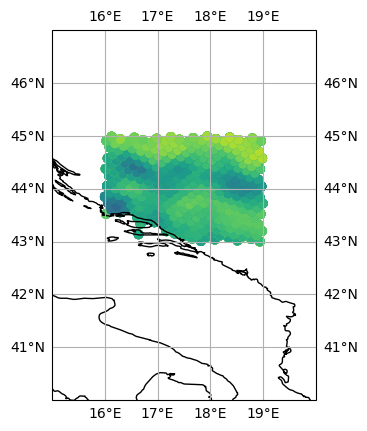

In [18]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([15, 20, 40, 47])
subset = cells_ds.sel(obs=(cells_ds["time"]>np.datetime64("2020-12-07")).compute())
subset = subset.gridds.sel_bbox((42,45,16,19))
subset.gridds.plot("surface_soil_moisture")

It&rsquo;s also still possible to do aggregations with flox, but unfortunately, aggregating along the observations dimension creates a new index and we lose all of our nice functions for working with grid IDs.

The situation isn&rsquo;t any worse than before we added the index, we just don&rsquo;t have a nice easy plot function anymore.

Example of getting average soil moisture per grid point:



In [19]:
from flox.xarray import xarray_reduce
avg_sm = xarray_reduce(subset, subset["location_id"], func="mean")
avg_sm

<xarray.Dataset> Size: 15MB
Dimensions:                            (location_id: 318, locations: 4000)
Coordinates:
    lon                                (locations) float32 16kB 18.94 ... 13.33
    lat                                (locations) float32 16kB 43.0 ... 51.0
    alt                                (locations) float32 16kB nan nan ... nan
  * location_id                        (location_id) int64 3kB 1121330 ... 11...
Dimensions without coordinates: locations
Data variables: (12/21)
    locationIndex                      (location_id) float64 3kB 0.0 ... 832.0
    as_des_pass                        (location_id) float32 1kB dask.array<chunksize=(318,), meta=np.ndarray>
    swath_indicator                    (location_id) float32 1kB dask.array<chunksize=(318,), meta=np.ndarray>
    surface_soil_moisture              (location_id) float32 1kB dask.array<chunksize=(318,), meta=np.ndarray>
    surface_soil_moisture_noise        (location_id) float32 1kB dask.array<chunksize=(318,), meta=np.ndarray>
    backscatter40                      (location_id) float32 1kB dask.array<chunksize=(318,), meta=np.ndarray>
    ...                                 ...
    wetland_fraction                   (location_id) float32 1kB dask.array<chunksize=(318,), meta=np.ndarray>
    topographic_complexity             (location_id) float32 1kB dask.array<chunksize=(318,), meta=np.ndarray>
    subsurface_scattering_probability  (location_id) float32 1kB dask.array<chunksize=(318,), meta=np.ndarray>
    sat_id                             (location_id) float32 1kB dask.array<chunksize=(318,), meta=np.ndarray>
    global_attributes_flag             (location_id, locations) float64 10MB ...
    location_description               (location_id, locations) <U1 5MB '' .....
Attributes: (12/16)
    title:             ASCAT surface soil moisture near real-time product
    summary:           ASCAT surface soil moisture expressed in degree of sat...
    doi:               unset
    keywords:          Metop-A ASCAT surface soil moisture
    history:           original generated product
    institution:       H SAF
    ...                ...
    environment:       Operational
    references:        h-saf.eumetsat.int
    software_version:  warp_h_nrt 0.0.0
    conventions:       CF-1.10
    featureType:       timeSeries
    grid_name:         Fib12.5

Or average soil moisture over an entire area for each of several periods:



In [20]:
xarray_reduce(subset, subset["time"].dt.hour, func="mean", expected_groups = np.unique(subset["time"].dt.hour))

<xarray.Dataset> Size: 385kB
Dimensions:                            (hour: 7, locations: 4000)
Coordinates:
    lon                                (locations) float32 16kB 18.94 ... 13.33
    lat                                (locations) float32 16kB 43.0 ... 51.0
    alt                                (locations) float32 16kB nan nan ... nan
  * hour                               (hour) int32 28B 7 8 9 17 18 19 20
Dimensions without coordinates: locations
Data variables: (12/21)
    locationIndex                      (hour) float64 56B dask.array<chunksize=(7,), meta=np.ndarray>
    as_des_pass                        (hour) float32 28B dask.array<chunksize=(7,), meta=np.ndarray>
    swath_indicator                    (hour) float32 28B dask.array<chunksize=(7,), meta=np.ndarray>
    surface_soil_moisture              (hour) float32 28B dask.array<chunksize=(7,), meta=np.ndarray>
    surface_soil_moisture_noise        (hour) float32 28B dask.array<chunksize=(7,), meta=np.ndarray>
    backscatter40                      (hour) float32 28B dask.array<chunksize=(7,), meta=np.ndarray>
    ...                                 ...
    wetland_fraction                   (hour) float32 28B dask.array<chunksize=(7,), meta=np.ndarray>
    topographic_complexity             (hour) float32 28B dask.array<chunksize=(7,), meta=np.ndarray>
    subsurface_scattering_probability  (hour) float32 28B dask.array<chunksize=(7,), meta=np.ndarray>
    sat_id                             (hour) float32 28B dask.array<chunksize=(7,), meta=np.ndarray>
    global_attributes_flag             (hour, locations) float64 224kB 1.0 .....
    location_description               (hour, locations) <U1 112kB '' '' ... ''
Attributes: (12/16)
    title:             ASCAT surface soil moisture near real-time product
    summary:           ASCAT surface soil moisture expressed in degree of sat...
    doi:               unset
    keywords:          Metop-A ASCAT surface soil moisture
    history:           original generated product
    institution:       H SAF
    ...                ...
    environment:       Operational
    references:        h-saf.eumetsat.int
    software_version:  warp_h_nrt 0.0.0
    conventions:       CF-1.10
    featureType:       timeSeries
    grid_name:         Fib12.5

Despite now lacking the custom index, we can make plots anyway, we just have to get the lats/lons by indexing the locations dimension (or some other way).



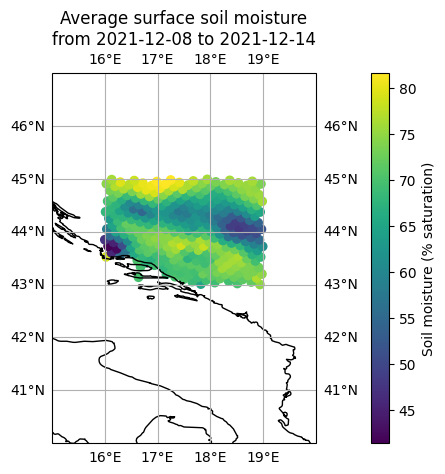

In [21]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([15, 20, 40, 47])
plt.scatter(avg_sm.lon[avg_sm["locationIndex"].astype(int)],
            avg_sm.lat[avg_sm["locationIndex"].astype(int)],
            c=avg_sm["surface_soil_moisture"].values)
plt.title("Average surface soil moisture\nfrom 2021-12-08 to 2021-12-14")
plt.colorbar(label="Soil moisture (% saturation)", pad=0.11)